In [10]:
import numpy as np
from skimage.measure import regionprops_table
import pandas as pd
import tifffile
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rc("axes", facecolor="#ffffff00", grid=False, edgecolor="k", labelcolor="k")
mpl.rc("figure", facecolor="#00000000", dpi=100)
mpl.rc("axes.spines", top=False, right=False, )
mpl.rc("xtick", color="k", bottom=True)
mpl.rc("ytick", color="k", left=True)
mpl.rc("legend", fontsize="small")

In [3]:
from laptrack import LapTrack
from tqdm import tqdm

def process_masks(masks, intensities):

    collect_spots = []

    for t, frame in tqdm(enumerate(masks)):
        props = regionprops_table(frame, intensity_image=np.moveaxis(intensities[t], 0, -1), properties=['label', 'area', 'centroid', "intensity_mean"])

        df = pd.DataFrame(props)
        df["frame"] = t
        df = df.rename(columns={"centroid-0": "px_y", "centroid-1": "px_x"})

        # print(df)

        collect_spots.append(df)

    spots_df = pd.concat([s for s in collect_spots], ignore_index=True)

    return spots_df


def track_spots(spots_df):
    max_distance = 20

    lt = LapTrack(
        metric="sqeuclidean",
        # The similarity metric for particles. See `scipy.spatial.distance.cdist` for allowed values.
        splitting_metric="sqeuclidean",
        merging_metric="sqeuclidean",
        gap_closing_metric="sqeuclidean",
        # the square of the cutoff distance for the "sqeuclidean" metric
        cutoff=max_distance ** 2,
        splitting_cutoff=False,  # or False for non-splitting case
        merging_cutoff=False,  # or False for non-merging case
        gap_closing_cutoff=max_distance ** 2,
        gap_closing_max_frame_count=2,
    )

    track_df, split_df, merge_df = lt.predict_dataframe(
        spots_df,
        coordinate_cols=[
            "px_x",
            "px_y",
        ],  # the column names for the coordinates
        frame_col="frame",  # the column name for the frame (default "frame")
        only_coordinate_cols=False,
    )

    track_df = track_df.rename(columns={"frame_y": "frame"})

    return track_df

In [5]:
base_dir = Path(r"D:\FeedbackControl\data\vortex")

# arr = tifffile.imread(base_dir / "cycle10.1_patterns.tif")

stem = "vor.04"

for stem in ["vor.02", "vor.03", "vor.05"]:
    arr = stem + "_patterns.tif"

    arr = tifffile.imread(base_dir / arr)
    arr = arr[:, :, 400:1200, 400:1200]

    print(arr.shape)

    masks = arr[:, 1]
    vals = arr[:, 0]

    print(masks.shape, vals.shape)

    spots = process_masks(masks, arr)
    tracked_spots_df = track_spots(spots)
    tracked_spots_df.to_csv(base_dir / f"{stem}_tracked.csv")

(209, 3, 800, 800)
(209, 800, 800) (209, 800, 800)


209it [00:21,  9.67it/s]


(209, 3, 800, 800)
(209, 800, 800) (209, 800, 800)


209it [00:21,  9.59it/s]


(209, 3, 800, 800)
(209, 800, 800) (209, 800, 800)


209it [00:14, 14.18it/s]


In [12]:
base_dir = Path(r"D:\FeedbackControl\data\vortex")
savepath = Path (r"G:\.shortcut-targets-by-id\1mjQpOyIBmhwFST1jB0FWKJhKOiVOMeb8\2025-03-24 Harrison feedback control\figure 3")

stem = "vor.01"
arr = stem + "_patterns.tif"

arr = tifffile.imread(base_dir / arr)
arr = arr[:, :, 400:1200, 400:1200]

tracks = pd.read_csv(base_dir / f"{stem}_tracked.csv")

print(tracks["px_x"].describe())

ss = tracks.copy()
ss = ss.sort_values("frame")
ss["x_rolling"] = ss.groupby("track_id").rolling(window=5, min_periods=1)["px_x"].mean().reset_index(level=0, drop=True)
ss["y_rolling"] = ss.groupby("track_id").rolling(window=5, min_periods=1)["px_y"].mean().reset_index(level=0, drop=True)
ss = ss[ss["frame"] < 12*16]

count    167673.000000
mean        400.575447
std         241.596785
min           0.000000
25%         185.612319
50%         399.939560
75%         617.310651
max         799.000000
Name: px_x, dtype: float64


In [6]:
import matplotlib as mpl
from collections import defaultdict
from tqdm import tqdm

# spots_df = pd.read_csv(base_dir / f"{stem}_tracked.csv")

all_subsets = []

for i in tqdm(range(1, 6)):

    stem = f"vor.0{i}"
    spots_df = pd.read_csv(base_dir / f"{stem}_tracked.csv")

    um_per_px = 0.66

    spots_df["id"] = spots_df.index
    spots_df["parent"] = spots_df.groupby("track_id").shift(1)["id"]
    spots_df["parent"] = spots_df["parent"].fillna(-1).astype(int)
    spots_df["um_x"] = spots_df["px_x"] * um_per_px
    spots_df["um_y"] = spots_df["px_y"] * um_per_px
    spots_df["t"] = spots_df["frame"] * 5
    spots_df["t_hour"] = spots_df["t"] // 60
    spots_df["t_2hour"] = spots_df["t"] // 120 * 2
    spots_df["dif_frame"] = spots_df["frame"] - spots_df.groupby("track_id").shift(1)["frame"]

    center_x, center_y = 400, 400
    center_x_um, center_y_um = center_x * um_per_px, center_y * um_per_px

    spots_df["um_r"] = np.sqrt((spots_df["um_x"] - center_x_um) ** 2 + (spots_df["um_y"] - center_y_um) ** 2)
    spots_df["theta"] = np.arctan2(spots_df["um_y"] - center_y_um, spots_df["um_x"] - center_x_um)

    spots_df["unit_tangent_x"] = -(spots_df["um_y"] - center_y_um) / spots_df["um_r"]
    spots_df["unit_tangent_y"] = (spots_df["um_x"] - center_x_um) / spots_df["um_r"]

    spots_df["unit_radial_x"] = (spots_df["um_x"] - center_x_um) / spots_df["um_r"]
    spots_df["unit_radial_y"] = (spots_df["um_y"] - center_y_um) / spots_df["um_r"]

    # print(spots_df["unit_tangent_y"].describe())

    for col in ["px_x", "px_y", "um_x", "um_y"]:
        spots_df[f"parent_{col}"] = spots_df.groupby("track_id").shift(1)[col]
        spots_df[f"dif_{col}"] = (spots_df[col] - spots_df[f"parent_{col}"]) / spots_df["dif_frame"]
        spots_df[f"{col}_per_min"] = spots_df[f"dif_{col}"] / 5
        spots_df[f"{col}_per_h"] = spots_df[f"dif_{col}"] * 12

    spots_df["um_tangent_per_min"] = -((spots_df["um_x_per_min"] * spots_df["unit_tangent_x"]) + (spots_df["um_y_per_min"] * spots_df["unit_tangent_y"]))
    spots_df["um_radial_per_min"] = (spots_df["um_x_per_min"] * spots_df["unit_radial_x"]) + (spots_df["um_y_per_min"] * spots_df["unit_radial_y"])

    spots_df["um_speed"] = np.sqrt(spots_df["um_x_per_min"] ** 2 + spots_df["um_y_per_min"] ** 2)

    spots_df["um_x_per_min_rolling"] = spots_df.groupby("track_id").rolling(window=10, min_periods=1)["um_x_per_min"].mean().reset_index(level=0, drop=True)
    spots_df["um_y_per_min_rolling"] = spots_df.groupby("track_id").rolling(window=10, min_periods=1)["um_y_per_min"].mean().reset_index(level=0, drop=True)
    spots_df["um_tangent_per_min_rolling"] = spots_df.groupby("track_id").rolling(window=10, min_periods=1)["um_tangent_per_min"].mean().reset_index(level=0, drop=True)
    spots_df["um_radial_per_min_rolling"] = spots_df.groupby("track_id").rolling(window=10, min_periods=1)["um_radial_per_min"].mean().reset_index(level=0, drop=True)

    spots_df["Tangential Velocity (um/h)"] = spots_df["um_tangent_per_min"] * 60
    spots_df["Radial Velocity (um/h)"] = spots_df["um_radial_per_min"] * 60

    spots_df["replicate"] = i

    subset = spots_df[
        (spots_df["t"].between(0, (60*10)-1))
    ].copy()

    all_subsets.append(subset)

frame_df = subset[subset["frame"] == 25].copy()




count    167673.000000
mean          0.007280
std           0.719782
min          -1.000000
25%          -0.713883
50%          -0.000375
75%           0.732091
max           1.000000
Name: unit_tangent_y, dtype: float64
count    165242.000000
mean         -0.021540
std           0.705573
min          -1.000000
25%          -0.715540
50%          -0.063138
75%           0.695533
max           1.000000
Name: unit_tangent_y, dtype: float64
count    178794.000000
mean          0.054707
std           0.712873
min          -1.000000
25%          -0.671630
50%           0.121366
75%           0.760396
max           1.000000
Name: unit_tangent_y, dtype: float64
count    156188.000000
mean         -0.006090
std           0.699817
min          -1.000000
25%          -0.695720
50%          -0.048486
75%           0.697639
max           1.000000
Name: unit_tangent_y, dtype: float64
count    117659.000000
mean         -0.020128
std           0.704126
min          -1.000000
25%          -0.711063
5

In [20]:
print(all_subsets[4].groupby("frame")["replicate"].count())

frame
0      349
1      355
2      358
3      355
4      361
      ... 
115    613
116    611
117    615
118    612
119    617
Name: replicate, Length: 120, dtype: int64


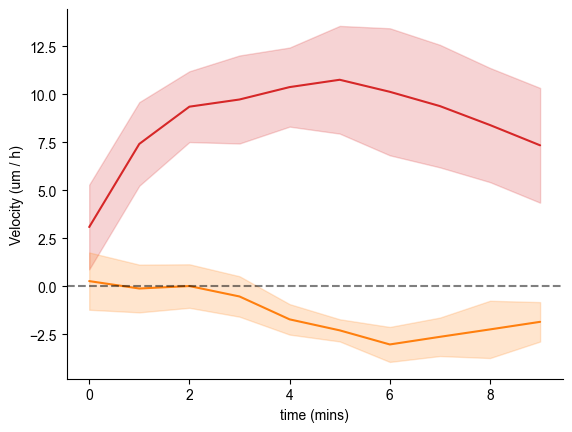

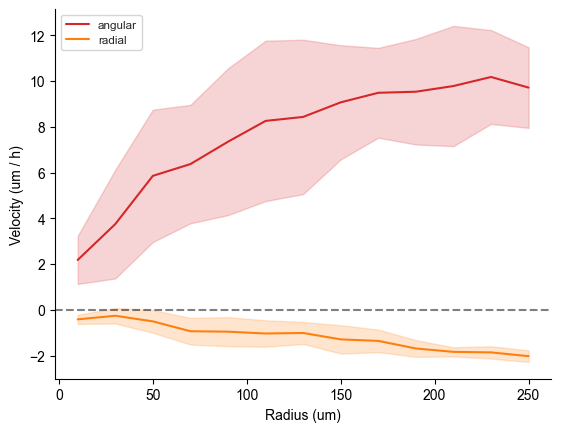

In [14]:
full_dfs = pd.concat(all_subsets, ignore_index=True)

t = full_dfs.groupby(["replicate", "t_hour"], as_index=False).mean()

sns.lineplot(t, x="t_hour", y="Tangential Velocity (um/h)", color="C3", errorbar=("sd", 1))
sns.lineplot(t, x="t_hour", y="Radial Velocity (um/h)", color="C1", errorbar=("sd", 1))
plt.xlabel("time (mins)")
plt.ylabel("Velocity (um / h)")
plt.axhline(0, color="black", linestyle="--", alpha=0.5)
# plt.legend()
plt.savefig(savepath / "vortex2_velocities.pdf")
plt.show()

full_dfs["um_r_bin"] = (full_dfs["um_r"] // 20) * 20 + 10

# plt.legend()
t = full_dfs.groupby(["replicate", "um_r_bin"], as_index=False).mean()

sns.lineplot(t[t["um_r_bin"] < 400/1.5], x="um_r_bin", y="Tangential Velocity (um/h)", errorbar=("sd", 1), err_style="band", label="angular", color="C3")
sns.lineplot(t[t["um_r_bin"] < 400/1.5], x="um_r_bin", y="Radial Velocity (um/h)", errorbar=("sd", 1), err_style="band", label="radial", color="C1")


plt.xlabel("Radius (um)")
plt.ylabel("Velocity (um / h)")
plt.axhline(0, color="black", linestyle="--", alpha=0.5)
plt.savefig(savepath / "vortex2_velocities_by_radius.pdf")
plt.show()

In [ ]:
x, y = frame_df["px_x"], frame_df["px_y"]
u, v = frame_df["um_x_per_min_rolling"], frame_df["um_y_per_min_rolling"]

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plt.quiver(x, y, u, v, angles='xy', scale_units='xy', color='black', alpha=0.5)

plt.show()

sns.lineplot(subset, x="t", y="Tangential Velocity (um/h)", errorbar=("sd", 1), err_style="band", label="angular", color="C3")
sns.lineplot(subset, x="t", y="Radial Velocity (um/h)", errorbar=("sd", 1), err_style="band", label="radial", color="C1")

plt.xlabel("time (mins)")
plt.ylabel("Velocity (um / h)")
plt.axhline(0, color="black", linestyle="--", alpha=0.5)
# plt.legend()
plt.savefig(savepath / "vortex2_velocities.pdf")
plt.show()

subset["um_r_bin"] = (subset["um_r"] // 20) * 20 + 10

sns.lineplot(subset[subset["um_r_bin"] < 400/1.5], x="um_r_bin", y="Tangential Velocity (um/h)", errorbar=("ci", 95), err_style="band", label="angular", color="C3")
sns.lineplot(subset[subset["um_r_bin"] < 400/1.5], x="um_r_bin", y="Radial Velocity (um/h)", errorbar=("ci", 95), err_style="band", label="radial", color="C1")

plt.xlabel("Radius (um)")
plt.ylabel("Velocity (um / h)")
plt.axhline(0, color="black", linestyle="--", alpha=0.5)
# plt.legend()
plt.savefig(savepath / "vortex2_velocities_by_radius.pdf")
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

plt.xlim(0, 800)
plt.ylim(0, 800)
plt.gca().set_aspect('equal')

sns.scatterplot(ss, x="x_rolling", y="y_rolling", hue="frame", legend=False, palette="Spectral", linewidth=0.0, s=0.5)

plt.savefig(savepath / "vortex_tracks_EXTREMEthin.png", dpi=450)
plt.savefig(savepath / "vortex_tracks.pdf")
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(4, 4))

plt.xlim(0, 800)
plt.ylim(0, 800)
plt.gca().set_aspect('equal')

sns.scatterplot(ss, x="x_rolling", y="y_rolling", hue="frame", legend=False, palette="Spectral", linewidth=0.0, s=1.0)

plt.savefig(savepath / "vortex_tracks_thin.png", dpi=450)
plt.savefig(savepath / "vortex_tracks.pdf")
plt.show()

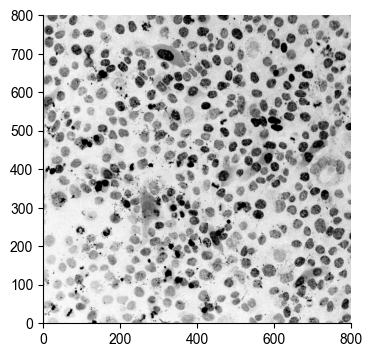

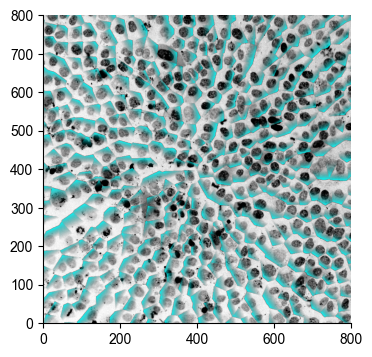

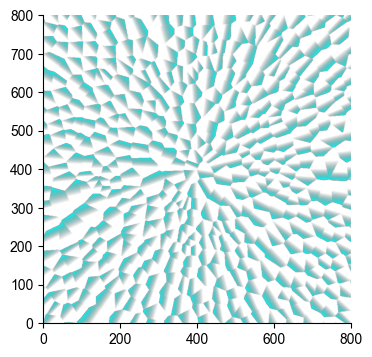

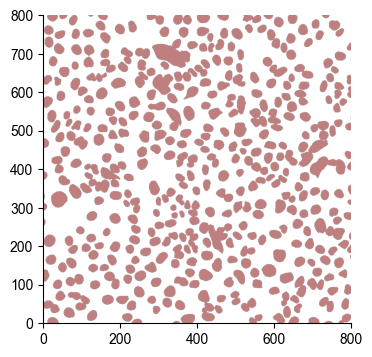

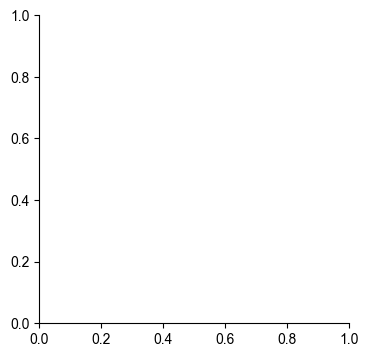

In [42]:


fig, ax = plt.subplots(1, 1, figsize=(4, 4))

plt.xlim(0, 800)
plt.ylim(0, 800)
plt.gca().set_aspect('equal')

# plt.imshow(arr[0, 0, 400:1200, 400:1200], cmap="gray", vmin=0, vmax=3000)
plt.imshow(arr[0, 0], cmap="binary", vmin=500, vmax=3000)
# plt.imshow(np.dstack([np.zeros(arr[1, 2].shape), arr[1, 2], arr[1, 2], arr[1, 2]]).astype(int))

# plt.gca().add_patch(circle)
# sns.scatterplot(ss, x="x_rolling", y="y_rolling", hue="frame", legend=False, palette="Spectral", linewidth=0.0, s=5.0)


plt.savefig(savepath / "vortex_just_img_inverted.pdf")
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(4, 4))

plt.xlim(0, 800)
plt.ylim(0, 800)
plt.gca().set_aspect('equal')

# plt.imshow(arr[0, 0, 400:1200, 400:1200], cmap="gray", vmin=0, vmax=3000)
plt.imshow(arr[0, 0], cmap="binary", vmin=500, vmax=3000)
plt.imshow(np.dstack([np.zeros(arr[1, 2].shape), arr[1, 2], arr[1, 2], arr[1, 2]]).astype(int))

# plt.gca().add_patch(circle)
# sns.scatterplot(ss, x="x_rolling", y="y_rolling", hue="frame", legend=False, palette="Spectral", linewidth=0.0, s=5.0)


plt.savefig(savepath / "vortex_just_img_inverted_with_pattern.pdf")
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(4, 4))

plt.xlim(0, 800)
plt.ylim(0, 800)
plt.gca().set_aspect('equal')

# plt.imshow(arr[0, 0, 400:1200, 400:1200], cmap="gray", vmin=0, vmax=3000)
# plt.imshow(arr[0, 0], cmap="binary", vmin=500, vmax=3000)
plt.imshow(np.dstack([np.zeros(arr[1, 2].shape), arr[1, 2], arr[1, 2], arr[1, 2]]).astype(int))

# plt.gca().add_patch(circle)
# sns.scatterplot(ss, x="x_rolling", y="y_rolling", hue="frame", legend=False, palette="Spectral", linewidth=0.0, s=5.0)


plt.savefig(savepath / "vortex_just_pattern.pdf")
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(4, 4))

plt.xlim(0, 800)
plt.ylim(0, 800)
plt.gca().set_aspect('equal')

# plt.imshow(arr[0, 0, 400:1200, 400:1200], cmap="gray", vmin=0, vmax=3000)
# plt.imshow(arr[0, 0], cmap="binary", vmin=500, vmax=3000)
a = 2*(arr[0, 1] > 0)
z = np.zeros(a.shape)
plt.imshow(np.dstack([a/2, z/8, z, a/2]).astype(int)*127)

# plt.gca().add_patch(circle)
# sns.scatterplot(ss, x="x_rolling", y="y_rolling", hue="frame", legend=False, palette="Spectral", linewidth=0.0, s=5.0)


plt.savefig(savepath / "vortex_just_segmentation.pdf")
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(4, 4))

tifffile.imwrite(savepath / "vortex_first_frame.tif", arr[0, 0], imagej=True)
tifffile.imwrite(savepath / "vortex_pattern_frame.tif", arr[1, 2], imagej=True)